In [1]:
import wandb
import lightning
import torch 
from model.commentary_models import ActualBoardTransformerMultipleHeadsModel
import sentencepiece
from typing import *
from data.ActualBoardCommentaryDataset import ActualBoardCommentaryDataset
from omegaconf import OmegaConf
import random 
import tqdm
import chess
from PIL import Image
from cairosvg import svg2png
from io import BytesIO


In [2]:
# artifact = wandb.Api().artifact('georgerapeanu/thesis/model-7gx683b3:v49', type='model')
# artifact_dir = artifact.download()

In [2]:
artifact_dir = "artifacts/model-7gx683b3:v49"

In [3]:
model = ActualBoardTransformerMultipleHeadsModel.load_from_checkpoint(artifact_dir + "/model.ckpt")

In [4]:
class ActualBoardPredictor:
    def __init__(
            self,
            context_length: int,
            sp: sentencepiece.SentencePieceProcessor
    ):
        self.__sp = sp
        self.__context_length = context_length

    def tokens_to_string(self, tokens: torch.Tensor) -> str:
        return self.__sp.decode(tokens.view(-1).tolist()).replace("<n>", "\n")

    def predict(self, model, X_board, X_strength, X_reps, X_state, text: str, max_new_tokens: int, target_type: Optional[int] = None) -> str:
        tokens = self.__sp.encode(text.strip().replace('\n', '<n>'))
        tokens = [self.__sp.bos_id()] + tokens
        X_board = X_board.to(model.device)
        X_strength = X_strength.to(model.device)
        X_reps = X_reps.to(model.device)
        X_state = X_state.to(model.device)
        tokens = torch.Tensor(tokens).unsqueeze(0).int().to(model.device)
        tokens = model.generate(X_board.unsqueeze(0), X_strength.unsqueeze(0), X_reps.unsqueeze(0), X_state.unsqueeze(0), tokens, max_new_tokens, target_type=target_type)
        return self.tokens_to_string(tokens)

In [16]:
sp = sentencepiece.SentencePieceProcessor("./artifacts/sp2000.model")
predictor = ActualBoardPredictor(512, sp)

In [17]:
conf = OmegaConf.create({
    "processed_path": "./processed_data",
    "split": "test",
    "count_past_boards": 2,
    "target_types": [0, 1, 2, 3, 4],
    "context_length": 512,
    "stride_big_sequences": 256,
})

engine_conf = OmegaConf.create({
    "mate_value": 10000
})
ds = ActualBoardCommentaryDataset(conf, engine_conf, sp)

In [18]:
choices = random.sample(range(len(ds)), 10)
to_predict = [ds[i] for i in choices]
to_predict_metadata = [ds.get_raw_data(i) for i in choices]


Prediction: 0it [00:00, ?it/s]

predicted: I'm not sure what this move is.
actual: 13. Na4 - but that white knight finds another square to harass my pieces.  This is b6 threatening a fork on Glenda and my rook on a8.


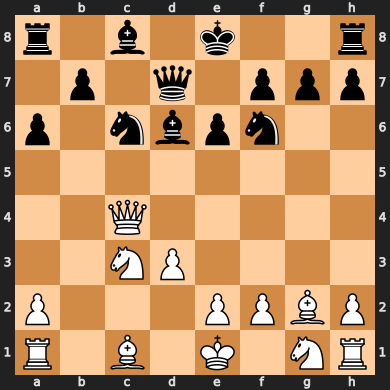

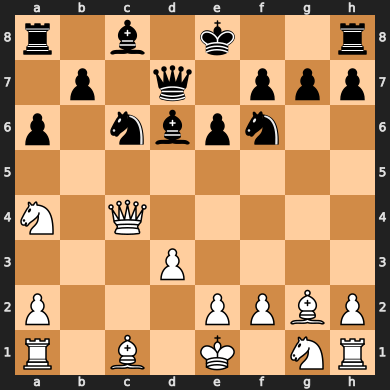

Prediction: 1it [00:00,  3.97it/s]

predicted: Black is now in trouble.
actual: My opponent takes a long time to come up with this move. The original speed of our first seven moves was long gone. But I knew I wouldn't give up even in this position, and began brainstorming how I'd fight back. And just as I was thinking "move a rook to d8," the move came. Move-mirroring indeed.


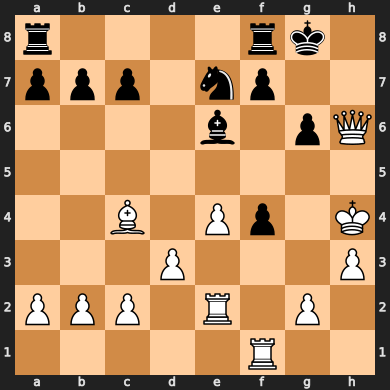

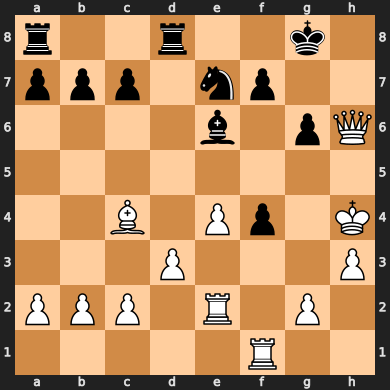

Prediction: 2it [00:00,  4.85it/s]

predicted: Black has a passed pawn.
actual: i calculated that my pawn would arrive first, and safe, due to the black queen and the white queen positions.


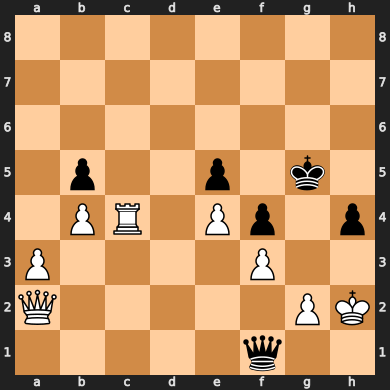

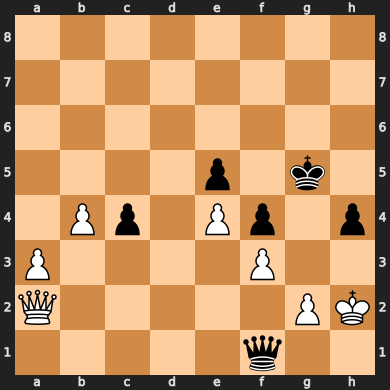

Prediction: 3it [00:00,  5.24it/s]

predicted: This is a good move, but it's not a good idea.
actual: I bring my selfless rook into the Battle.


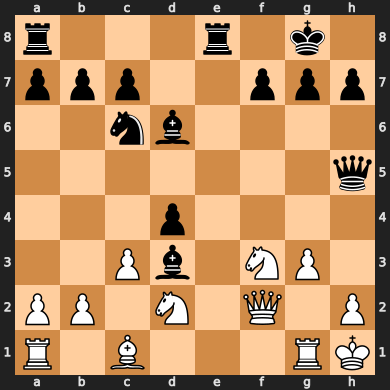

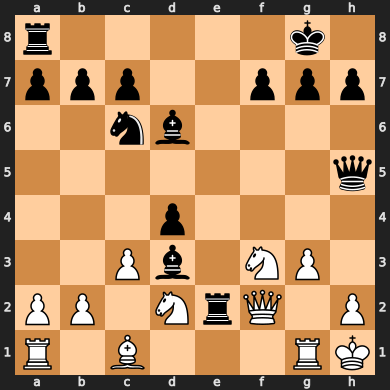

Prediction: 4it [00:00,  4.15it/s]

predicted: I don't know why I played this move.
actual: I can get a free pawn and keep b5 defended -- now 4 pawns ahead.


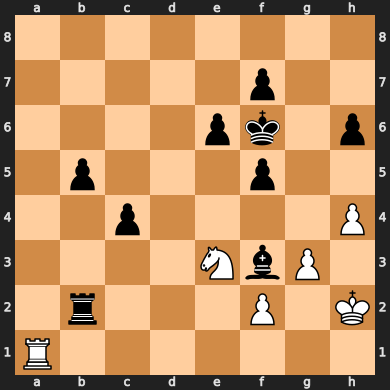

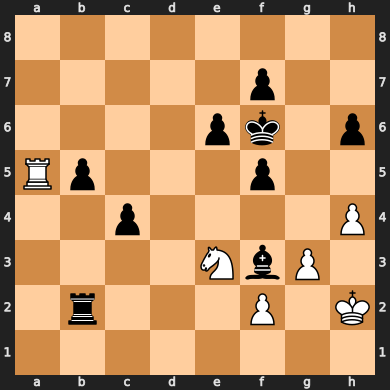

Prediction: 5it [00:01,  4.31it/s]

predicted: I'm not sure what this move is.
actual: Hoping to force a queen trade with 23...Qb4 24. Qc3 Qxc3 25. Bxc5 
If queen b7, then rook a7 wins a piece.


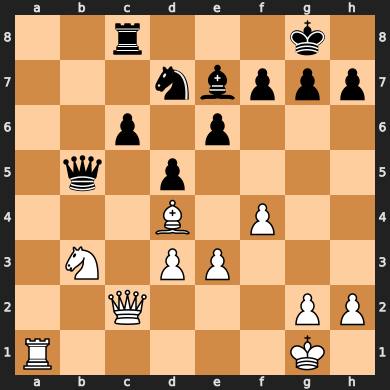

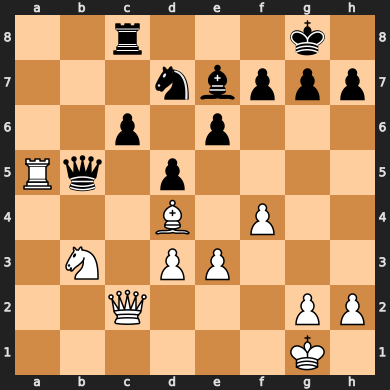

Prediction: 6it [00:01,  4.27it/s]

predicted: I'm not sure what this is called. I'm playing black.
actual: decided to try sicilian


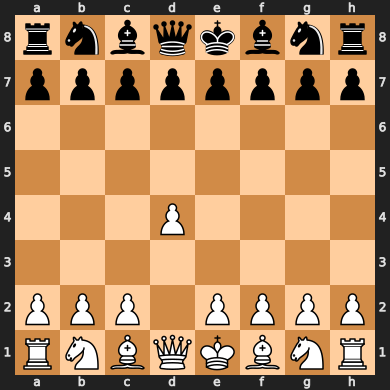

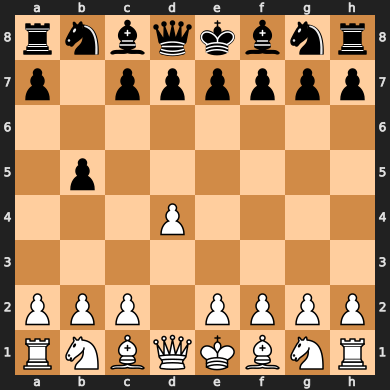

Prediction: 7it [00:01,  3.70it/s]

predicted: 44. ............. Kxc4 - I have to be careful here.  I think I have a passed pawn on the kingside.  I have to move my king to the kingside.  I think I'm not sure that this is the best move.
actual: My plan was ...fxg4 and White has three connected, passed pawns against Blacks two. White have then the possibility to block Blacks two passed pawns with his King!


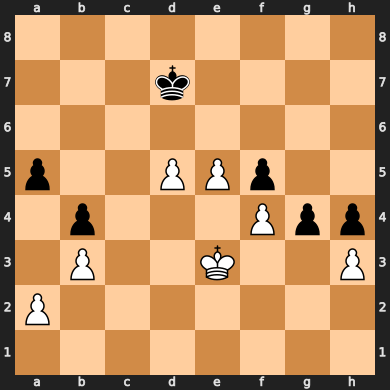

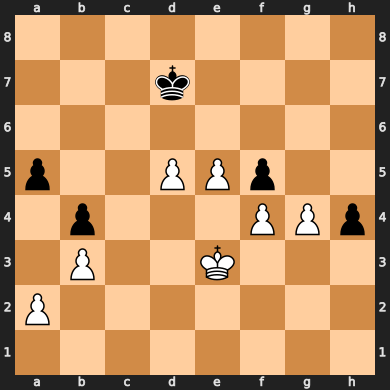

Prediction: 8it [00:02,  2.15it/s]

predicted: I'm not sure why I played this move.
actual: The black king is alone and the Bxe5 gives pain.


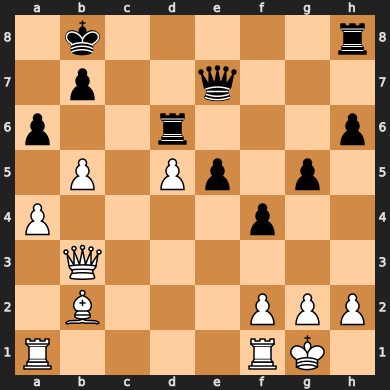

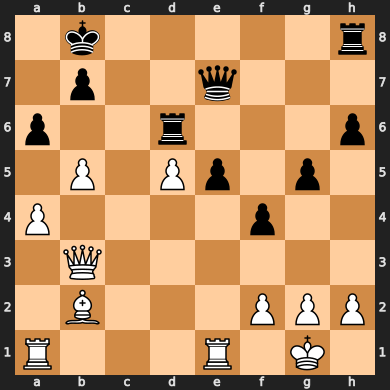

Prediction: 9it [00:02,  2.50it/s]

predicted: This is a very good move for black.
actual: Just weak? Maybe, but white still has b5 for his pieces. I can allow myself to play slower than average. a6-c5 was the natural and good plan, but it was too explored. I'll try something else.


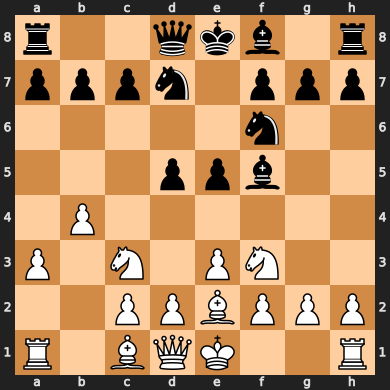

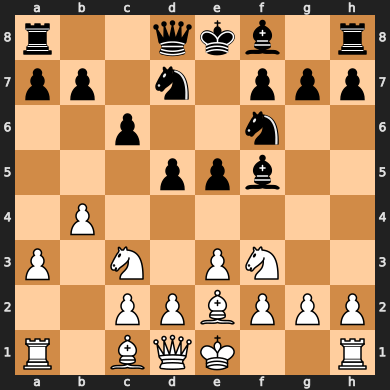

Prediction: 10it [00:03,  3.24it/s]


In [19]:
model.eval()

for ((X_board, X_strength, X_reps, X_state, y_tokens, _), (current_board, past_board, current_eval, past_eval)) in tqdm.tqdm(zip(to_predict, to_predict_metadata), desc="Prediction"):
            predicted_text = predictor.predict(model, X_board, X_strength, X_reps, X_state, '', 1024, target_type=4)
            actual_text = predictor.tokens_to_string(y_tokens)
            past = Image.open(BytesIO(
                    svg2png(chess.svg.board(None if past_board is None else chess.Board(past_board))))).convert(
                    'RGBA')
            curr = Image.open(BytesIO(
                    svg2png(chess.svg.board(None if past_board is None else chess.Board(current_board))))).convert(
                    'RGBA')
            print(f"predicted: {predicted_text}")
            print(f"actual: {actual_text}")
            display(past)
            display(curr)

In [9]:
# torch.jit.save(model.to_torchscript(), "./artifacts/model.pt")